In [1]:
!pip install pymorphy3
!pip install catboost
!pip install transformers
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 881.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [47]:
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from pymorphy3 import MorphAnalyzer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertForSequenceClassification, BertTokenizer, TrainingArguments, Trainer, RobertaForSequenceClassification, RobertaTokenizer, AutoTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, f1_score, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from wordcloud import WordCloud
import torch.nn.functional as F
import torch
from torch import nn
from tqdm import tqdm
from catboost import CatBoostClassifier
import warnings


warnings.filterwarnings('ignore')

## Preprocess texts

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/My Drive/Term/texts_labeled.tsv'
# path = '/Users/nikitasenyatkin/Documents/Мага/2 курс/Thesis/wb-category-analysis/texts_labeled.tsv'

In [5]:
df = pd.read_csv(path, sep='\t')

In [6]:
res = df.groupby('INPUT:comment')['OUTPUT:is_infringements'].apply(lambda row: row.value_counts().idxmax()).reset_index()
res.head()

,INPUT:comment,OUTPUT:is_infringements
0,\r\nВРЕМЯ ПИТЬ ЧАЙ!\r\nBrusnikaTea «ЯГОДНЫЙ» -...,yes
1,\r\nВкусный чай зеленый листовой ягодами земля...,no
2,\r\nИван чай Глазова Гора – традиционный русск...,no
3,\r\nИщете идеальный подарок на Новый год? Пода...,no
4,\r\nНастоящий Молочный улун высший сорт из Кит...,yes


In [7]:
df[df['INPUT:comment'] == '\r\nВкусный чай зеленый листовой ягодами земляники. Земляничный улун подарочный. Улун китайский и ягоды сушеные (земляника сублимированная) возвратят Вас в лето и превратят чаепитие в праздник. Сублимированные ягоды и крупнолистовой зелёный чай укрепят здоровье. Содержит витамины D, C, E, K, марганец, фосфор, железо и йод. Чай заварной с натуральными добавками выводит шлаки и токсины из организма. Напиток можно использовать для детокса и похудения. Чай с ягодами имеет обволакивающий вкус и нежный аромат. Фруктовый чай натуральный антиоксидант, полезен для похудения, укрепляет костные ткани. Чайное ассорти изготовлено без искусственных красителей и не содержит ГМО. Чай подарочный ягодный микс в подарок женщине, мужчине. Чай с фруктами можно подать во время застолья на новогодний праздник. Оригинальный и нежный вкус наверняка понравится гостям. Состав: чай китайский улун, ягоды земляники, лист брусники, натуральный земляничный ароматизатор. После него Вы забудете про чай в пакетиках. сушеные ягоды, лепестки и травы - чайный напиток с натуральными витаминами и полезными минералами. Практичный, универсальный подарок с пользой для здоровья удивит и вызовет положительные эмоции, а также даст повод собраться с друзьями и родными за чашечкой чая. После него Вы забудете про чай в пакетиках. Тонизирующее, так и успокаивающее воздействие. ']

,INPUT:comment,OUTPUT:insult,OUTPUT:nonsense,OUTPUT:profanity,OUTPUT:advertising,OUTPUT:law_violation,OUTPUT:is_infringements,GOLDEN:insult,GOLDEN:nonsense,GOLDEN:profanity,...,GOLDEN:law_violation,GOLDEN:is_infringements,HINT:text,HINT:default_language,ASSIGNMENT:link,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ASSIGNMENT:started
4853,\r\nВкусный чай зеленый листовой ягодами земля...,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,https://platform.toloka.ai/task/42935533/00028...,00028f24ed--661febdf1c7df82555cadd30,00028f24ed--661ff1997d5f9b2330ba2f9c,5f271f4fb1d5d003e454617253cc57d8,APPROVED,2024-04-17T15:58:17.613
4901,\r\nВкусный чай зеленый листовой ягодами земля...,NaN,NaN,NaN,True,NaN,yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,https://platform.toloka.ai/task/42935533/00028...,00028f24ed--661febdf1c7df82555cadd30,00028f24ed--661ff19bdaf59030df3c69c2,bfdb99f582393c82a7545545bc7044fb,APPROVED,2024-04-17T15:58:19.082
4953,\r\nВкусный чай зеленый листовой ягодами земля...,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,https://platform.toloka.ai/task/42935533/00028...,00028f24ed--661febdf1c7df82555cadd30,00028f24ed--661ff19cdaf59030df3c69f7,2a38e4d4e4a4736d579c9e52f33b9075,APPROVED,2024-04-17T15:58:20.522


In [8]:
names = {
    'INPUT:comment' : 'comment',
    'OUTPUT:is_infringements' : 'target'
}

In [9]:
res.rename(names, axis=1, inplace=True)

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
patterns = '[^0-9а-яА-ЯёЁ\s]+'
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]

            tokens.append(token)
    return tokens

In [12]:
def preprocess_text(row):

    text = str(row).lower()

    # deleting punctuation
    punc = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(punc)

    # lemmatizing
    lematized_text = lemmatize(text_no_punct)

    return lematized_text

In [13]:
def target_labeler(s):
    if s == 'yes':
        return 1
    if s == 'avg':
        return 1
    else:
        return 0

In [14]:
preprocessed_df = res.copy()
preprocessed_df['comment'] = res['comment'].apply(preprocess_text)
preprocessed_df['target'] = preprocessed_df['target'].apply(lambda row: target_labeler(row))
preprocessed_df.head()

,comment,target
0,"[время, пить, чай, ягодный, авторский, сбор, в...",1
1,"[вкусный, чай, зелёный, листовой, ягода, земля...",0
2,"[иван, чай, глазов, гора, традиционный, русски...",0
3,"[искать, идеальный, подарок, новый, год, подар...",0
4,"[настоящий, молочный, улуна, высокий, сорт, ки...",1


Опробовать сетки отсюда, если нет, то гг, придется что- то думать.
В противном случае генерация описаний или придумывание описательных фичей текста, которые могут помочь, вместо стандартных векторов

## Training embeddings


In [32]:
# creating tagged data
tagged_data = [TaggedDocument(words=d, tags=[str(i)]) for i, d in enumerate(preprocessed_df['comment'])]

# creating model
model = Doc2Vec(vector_size=25, window=7, min_count=2, workers=4, seed=42, dm=True)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=5)

# receiving vecs
vectors = pd.DataFrame(model.infer_vector(doc.words) for doc in tagged_data)
# vectors = pd.DataFrame(model.dv.get_vector(str(i)) for i in range(len(tagged_data)))



In [33]:
def target_labeler(s):
    if s == 'yes':
        return 1
    if s == 'avg':
        return 1
    else:
        return 0

def counter(class_name):
    return preprocessed_df['target'].count()/preprocessed_df['target'][preprocessed_df['target']==class_name].count()

In [34]:
cb_df = pd.concat([vectors, preprocessed_df['target']], axis=1)
# cb_df['target'] = cb_df['target'].apply(lambda row: target_labeler(row))
# weights = [counter(0), counter(1), counter(2)]
cb_df.head()


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,target
0,0.065466,-0.521526,0.255687,-0.533177,-0.807823,-0.351070,0.309721,0.059911,-0.242803,-0.194652,...,0.135775,-0.016796,-0.410891,0.120055,-0.100096,0.047493,0.765578,0.366676,0.064604,1
1,-0.231070,0.023460,-0.230618,-0.138327,0.035295,0.066777,-0.034606,0.032195,-0.085885,-0.061668,...,0.141059,0.073667,0.224319,-0.035234,0.193792,0.160310,-0.025784,-0.468950,0.242226,0
2,-0.160774,-0.114878,0.037936,-0.199076,-0.246751,0.033533,-0.055556,0.127496,0.014482,0.008331,...,0.319456,-0.211840,-0.210200,0.073527,-0.307160,-0.047210,0.293521,0.300439,0.050311,0
3,-0.530483,-0.089545,-0.601369,-0.193838,0.234597,-0.162996,0.045947,-0.093853,-0.068701,-0.059396,...,0.524710,-0.339836,0.553221,-0.471778,0.401120,-0.567594,0.090470,-0.440926,0.614204,0
4,0.070476,-0.205423,0.221015,-0.102215,-0.111708,0.040680,-0.243057,-0.045496,-0.207865,-0.110980,...,-0.234935,-0.210961,-0.398957,0.306205,-0.167552,0.141671,0.353182,0.087012,-0.056075,1


In [35]:
cb_df.target.value_counts()

target
0    1307
1     701
Name: count, dtype: int64

In [36]:
X = cb_df.drop('target', axis=1)

positive_indices = [i for i, label in enumerate(cb_df['target']) if label == 1]
negative_indices = [i for i, label in enumerate(cb_df['target']) if label == 0]

positive_vectors = X.loc[positive_indices]
negative_vectors = X.loc[negative_indices]

KNN for filtering data

In [37]:
def knn_pos_filtering(positive_vectors, negative_vectors, thresh):

  knn_model_pos = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
  knn_model_pos.fit(positive_vectors)

  distances, indices = knn_model_pos.kneighbors(negative_vectors)

  result = set()
  for i, (s, dist, idx) in enumerate(zip(negative_indices, distances, indices)):
      if dist.mean() < thresh:
        result.add(s)
  return list(result)


In [38]:
pos_filtering_bad_idx = knn_pos_filtering(positive_vectors, negative_vectors, 0.47)
print(len(pos_filtering_bad_idx))
print(preprocessed_df.loc[pos_filtering_bad_idx]['target'].value_counts())

718
target
0    718
Name: count, dtype: int64


In [39]:
def knn_neg_filtering(positive_vectors, negative_vectors, thresh):

  knn_model_pos = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
  knn_model_pos.fit(negative_vectors)

  distances, indices = knn_model_pos.kneighbors(positive_vectors)

  result = set()
  for distance in range(len(distances)):
    for i in range(3):
      if distances[distance][i] < thresh:
        result.add(negative_indices[indices[distance][i]])
  return list(result)


In [40]:
neg_filtering_bad_idx = knn_neg_filtering(positive_vectors, negative_vectors, 1.3)
print(len(neg_filtering_bad_idx))
print(preprocessed_df.loc[neg_filtering_bad_idx]['target'].value_counts())

891
target
0    891
Name: count, dtype: int64


In [41]:
# res.drop(neg_filtering_bad_idx)['target'].value_counts()
cb_df.drop(pos_filtering_bad_idx)['target'].value_counts()


target
1    701
0    589
Name: count, dtype: int64

## Logistic regression on doc2vec test

In [42]:
df = cb_df.drop(pos_filtering_bad_idx)
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
model = LogisticRegression()

model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)

acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, proba[:,1])

print(acc, f1, roc_auc)

0.640926640926641 0.6990291262135921 0.6733381416035582


In [27]:
model = LogisticRegression(penalty='l2', C=3)

model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)

acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, proba[:,1])
print(acc, f1, roc_auc)

0.6486486486486487 0.7035830618892509 0.6751412429378532


## Catboost + Doc2Vec

In [43]:
cb = CatBoostClassifier(learning_rate=0.03, random_seed=42)
cb.fit(X_train, y_train, verbose=0)
pred = cb.predict(X_test)

proba = cb.predict_proba(X_test)
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, proba[:,1])
print(acc, f1, roc_auc)

0.751937984496124 0.7647058823529412 0.8267554479418887


In [44]:
cb = CatBoostClassifier(
     early_stopping_rounds=100,
     learning_rate=0.01,
     random_seed=42,
     l2_leaf_reg=5,
     depth=8,
     leaf_estimation_method='Newton')
cb.fit(X_train, y_train, verbose=0)
pred = cb.predict(X_test)
proba = cb.predict_proba(X_test)
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, proba[:,1])
print(acc, f1, roc_auc)

0.7713178294573644 0.7822878228782287 0.8338983050847457


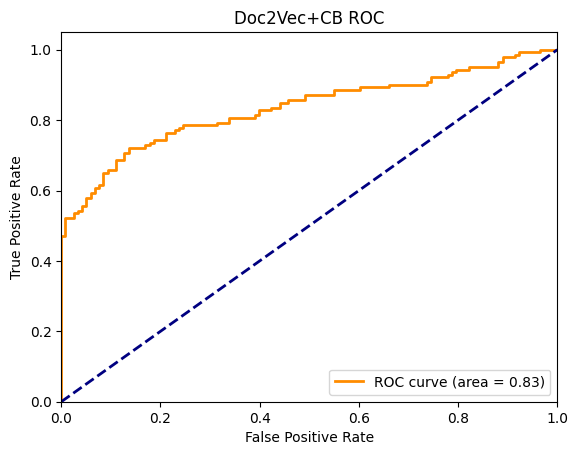

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Doc2Vec+CB ROC')
plt.legend(loc="lower right")
plt.show()

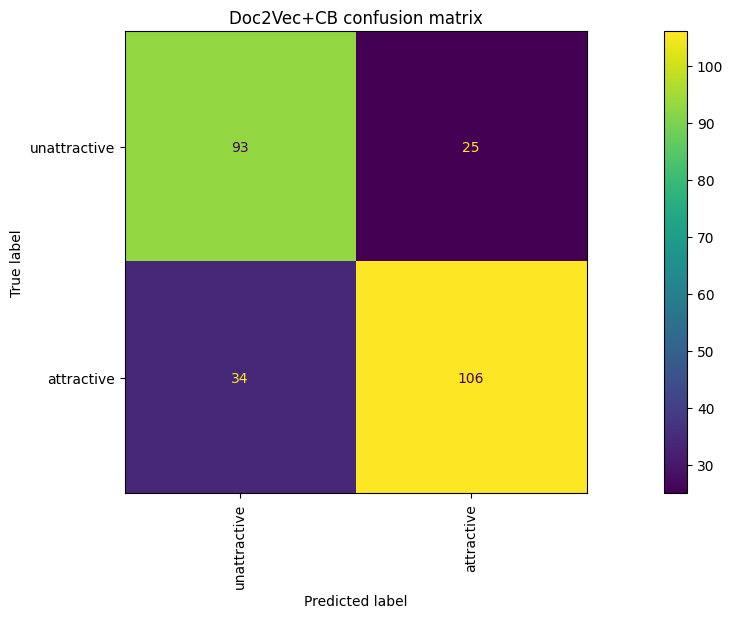

In [50]:
cm = confusion_matrix(y_test, pred)
# mapped_labels = [map[label] for label in sorted(map.keys())]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['unattractive', 'attractive'])
fig, ax = plt.subplots(figsize=(20, 6))
disp.plot(ax=ax)
plt.title('Doc2Vec+CB confusion matrix')

plt.xticks(rotation=90)

plt.show()

## SVM + doc2vec

In [ ]:
svc = SVC(probability=True)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)

proba = svc.predict_proba(X_test)
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, proba[:,1])
print(acc, f1, roc_auc)

0.6987951807228916 0.7232472324723247 0.7882044560943643


0.7882044560943643


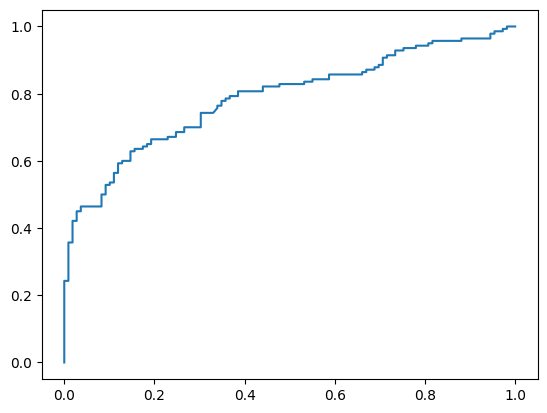

In [ ]:
pred = svc.predict_proba(X_test)

print(roc_auc_score(y_test, pred[:,1]))

fpr, tpr, thres = roc_curve(y_test, pred[:,1])

plt.plot(fpr, tpr)

Logistic regression + doc2vec filtration + TFIDF

In [ ]:
tf_data = preprocessed_df.drop(pos_filtering_bad_idx)
tf_data['comment'] = tf_data['comment'].apply(lambda row: ' '.join(row))
X = tf_data.drop('target', axis=1)
y = tf_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
tfidf_1 = TfidfVectorizer(ngram_range=(1, 1))


In [ ]:
tfidf_train = tfidf_1.fit_transform(X_train['comment'])
tfidf_test = tfidf_1.transform(X_test['comment'])

print(tfidf_train.shape)
print(tfidf_test.shape)

(1094, 9137)
(274, 9137)


In [ ]:
model = LogisticRegression(penalty='l2', C=3)

model.fit(tfidf_train, y_train)
pred = model.predict(tfidf_test)

proba = model.predict_proba(tfidf_test)
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, proba[:,1])
print(acc, f1, roc_auc)

0.6459854014598541 0.6472727272727272 0.700053304904051


## Визуализация

In [ ]:
weights = pd.DataFrame({'words': tfidf_1.get_feature_names_out(),
                        'weights': model.coef_.flatten()})
weights_min = weights.sort_values(by= 'weights')
weights_max = weights.sort_values(by= 'weights', ascending = False)

In [ ]:
weights_min = weights_min[:100]
weights_min['weights'] = weights_min['weights'] * -1
weights_min

,words,weights
7668,также,2.204364
8682,чай,2.184555
1898,день,2.082109
4173,напиток,1.953106
5059,очень,1.863917
...,...,...
8562,цветковый,0.884293
32,13,0.882291
5676,попробовать,0.880739
8758,человек,0.880538


In [ ]:
weights_max = weights_max[:100]
weights_max

,words,weights
3914,минута,1.521517
5978,придавать,1.480095
6979,сила,1.477745
5090,пакет,1.387558
6359,пёкий,1.291553
...,...,...
3513,лепесток,0.682183
9010,эра,0.677869
5370,повод,0.674697
4231,настолько,0.674252


In [ ]:
wordcloud_positive = WordCloud(background_color="white",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None,
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_max.values))

wordcloud_negative = WordCloud(background_color="black",
                               colormap = 'Reds',
                               max_words=200,
                               mask=None,
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_min.values))

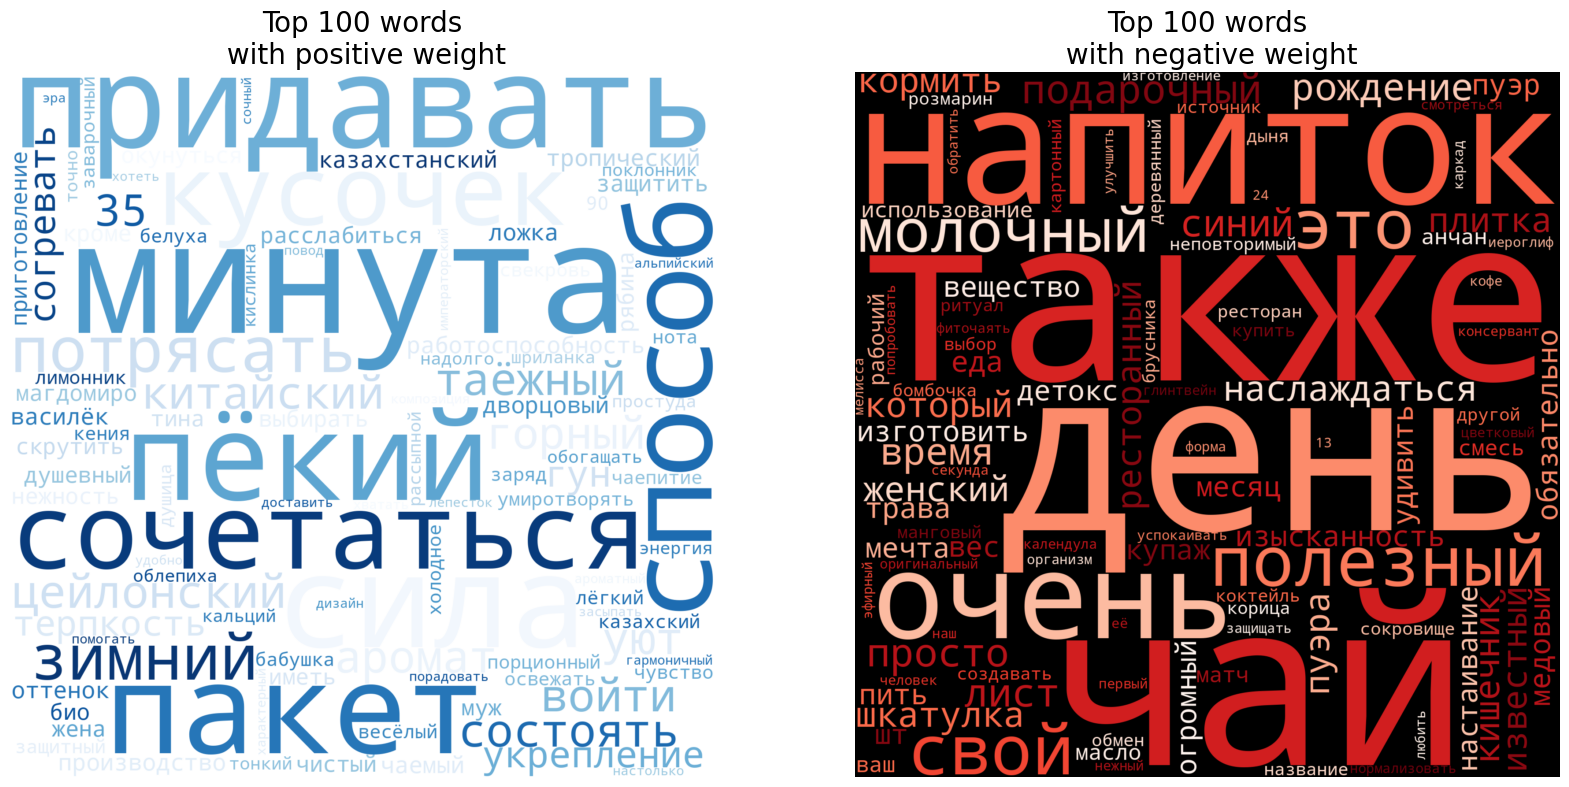

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 12))


ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[1].imshow(wordcloud_negative, interpolation='bilinear')

ax[0].set_title('Top ' +\
                str(weights_max.shape[0]) +\
                ' words\n with positive weight',
               fontsize = 20
               )
ax[1].set_title('Top ' +\
                str(weights_min.shape[0]) +\
                ' words\n with negative weight',
               fontsize = 20
               )

ax[0].axis("off")
ax[1].axis("off")

plt.show()

## CATBOOST + TFIDF

In [ ]:
cb = CatBoostClassifier(early_stopping_rounds=100, learning_rate=0.01, random_seed=42)
cb.fit(tfidf_train, y_train, verbose=0)
pred = cb.predict(tfidf_test)

acc = accuracy_score(y_test, pred)
print(acc)

0.6934306569343066


0.7682302771855011


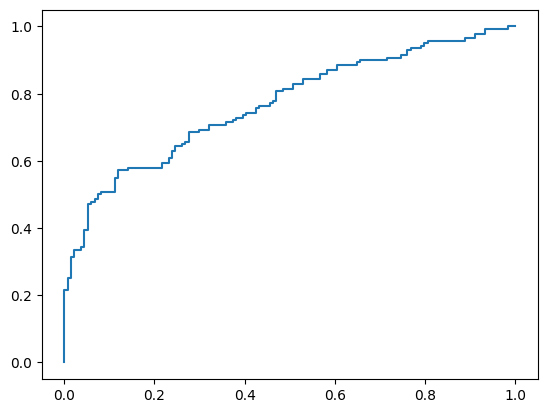

In [ ]:
pred = cb.predict_proba(tfidf_test)

print(roc_auc_score(y_test, pred[:,1]))

fpr, tpr, thres = roc_curve(y_test, pred[:,1])

plt.plot(fpr, tpr)

TFIDF works worse, so let's try DOC2VEC + LSTM

## Попробуем TFIDF + Удаление слов по типу чая и LR + CB

In [ ]:
def deletor(s):
  ban = ['чай', 'напиток']
  res = []
  for i in s:
    if i not in ban:
      res.append(i)

  return res


In [ ]:
tf_data = preprocessed_df.drop(pos_filtering_bad_idx)
tf_data['comment'] = tf_data['comment'].apply(lambda row: deletor(row))
tf_data['comment'] = tf_data['comment'].apply(lambda row: ' '.join(row))
X = tf_data.drop('target', axis=1)
y = tf_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
tfidf_1 = TfidfVectorizer(ngram_range=(1, 1))


In [ ]:
tfidf_train = tfidf_1.fit_transform(X_train['comment'])
tfidf_test = tfidf_1.transform(X_test['comment'])

print(tfidf_train.shape)
print(tfidf_test.shape)

(1094, 8993)
(274, 8993)


In [ ]:
model = LogisticRegression()

model.fit(tfidf_train, y_train)
pred = model.predict(tfidf_test)

acc = accuracy_score(y_test, pred)
print(acc)

0.6605839416058394


In [ ]:
cb = CatBoostClassifier(early_stopping_rounds=100, learning_rate=0.01, random_seed=42)
cb.fit(tfidf_train, y_train, verbose=0)
pred = cb.predict(tfidf_test)

acc = accuracy_score(y_test, pred)
print(acc)

0.6788321167883211


## Без чая с doc2vec

In [ ]:
del_df = preprocessed_df.copy()
del_df['comment'] = del_df['comment'].apply(lambda row: deletor(row))
# creating tagged data
tagged_data = [TaggedDocument(words=d, tags=[str(i)]) for i, d in enumerate(del_df['comment'])]

# creating model
model = Doc2Vec(vector_size=25, window=2, min_count=1, workers=4, seed=42)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=5)

# receiving vecs
vectors = pd.DataFrame(model.infer_vector(doc.words) for doc in tagged_data)
# vectors = pd.DataFrame(model.dv.get_vector(str(i)) for i in range(len(tagged_data)))



In [ ]:
cb_df = pd.concat([vectors, del_df['target']], axis=1)
# cb_df['target'] = cb_df['target'].apply(lambda row: target_labeler(row))
# weights = [counter(0), counter(1), counter(2)]
cb_df.head()


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,target
0,0.191264,-0.663872,-0.105558,-0.607339,-0.179706,-0.194606,-0.131592,0.191703,-0.122004,-0.636673,...,0.515386,0.153488,-0.768717,-0.382476,0.037204,0.368475,0.957181,0.252566,0.507502,1
1,0.244200,0.112973,-0.037115,-0.023589,-0.109951,-0.040564,-0.048558,0.100185,-0.260231,-0.069736,...,0.484316,0.136784,-0.098018,-0.163407,-0.053709,-0.240241,0.175918,0.026871,0.110661,0
2,0.197036,-0.389644,0.071729,-0.264817,-0.189419,-0.284165,0.025597,0.084019,0.031729,-0.039751,...,0.203152,0.073453,-0.480048,-0.314616,0.061448,0.115194,0.287471,0.261535,0.230946,0
3,0.396488,-0.004994,-0.101552,-0.235894,0.013826,-0.509028,-0.155160,-0.064371,-1.092907,0.206538,...,0.820696,-0.010048,-0.166510,-0.501521,-0.201602,-0.211958,0.833962,0.296002,0.224930,0
4,0.120704,-0.251390,-0.536338,-0.253087,-0.095883,-0.243507,0.052087,0.133031,0.236617,-0.398681,...,0.660897,0.217084,-0.308246,0.355267,0.063808,0.109078,0.446108,0.669860,0.037884,1


In [ ]:
X = cb_df.drop('target', axis=1)

positive_indices = [i for i, label in enumerate(cb_df['target']) if label == 1]
negative_indices = [i for i, label in enumerate(cb_df['target']) if label == 0]

positive_vectors = X.loc[positive_indices]
negative_vectors = X.loc[negative_indices]

In [ ]:
pos_filtering_bad_idx = knn_pos_filtering(positive_vectors, negative_vectors, 0.52)
print(len(pos_filtering_bad_idx))
print(preprocessed_df.loc[pos_filtering_bad_idx]['target'].value_counts())

693
target
0    693
Name: count, dtype: int64


In [ ]:
cb_df.drop(pos_filtering_bad_idx)['target'].value_counts()


target
1    701
0    614
Name: count, dtype: int64

In [ ]:
df = cb_df.drop(pos_filtering_bad_idx)
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
model = LogisticRegression()

model.fit(X_train, y_train)
pred = model.predict(X_test)

acc = accuracy_score(y_test, pred)
print(acc)

0.6387832699619772


In [ ]:
cb = CatBoostClassifier(early_stopping_rounds=100, learning_rate=0.01, random_seed=42)
cb.fit(X_train, y_train, verbose=0)
pred = cb.predict(X_test)

acc = accuracy_score(y_test, pred)
print(acc)

0.7338403041825095


0.764924506387921


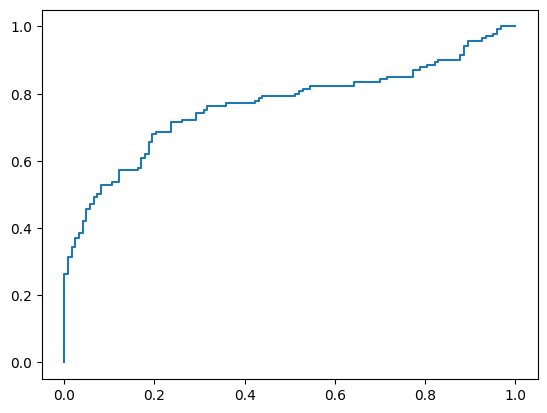

In [ ]:
pred = cb.predict_proba(X_test)

print(roc_auc_score(y_test, pred[:,1]))

fpr, tpr, thres = roc_curve(y_test, pred[:,1])

plt.plot(fpr, tpr)

## FC + DOC2VEC

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
l_df = cb_df.copy()
X = l_df.drop('target', axis=1)
y = l_df['target']

features = X.values
targets = y.values

X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=42, test_size=0.8, stratify=y)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
vocab_size = 2000
input_len = 25
hidden_size = 128
num_layers = 2
num_classes = 2
n_epochs = 5
learning_rate = 0.001

In [ ]:
class FC(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(input_size, 128, bias=True)
        self.fc2 = nn.Linear(128, num_classes, bias=True)

        self.dropout1 = nn.Dropout(0.4)


    def forward(self, X):
        out = F.relu(self.fc1(X))
        out = self.dropout1(out)
        out = F.relu(self.fc2(out))

        return out


In [ ]:
model = FC(input_len, num_classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
criterion = nn.CrossEntropyLoss()

num_epochs = 500

for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.train()  # Переключение в режим обучения
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_classes = torch.max(outputs, 1)
        correct_predictions = (predicted_classes == targets).float()
        total_correct += correct_predictions.sum().item()
        total_samples += targets.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    print(f"TRAIN: Epoch {epoch + 1}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")


    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted_classes = torch.max(outputs, 1)
            correct_predictions = (predicted_classes == targets).float()
            total_correct += correct_predictions.sum().item()
            total_samples += targets.size(0)

    average_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples
    print(f"TEST: Epoch {epoch + 1}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
    print('='*30)

TRAIN: Epoch 1, Average Loss: 0.6660, Accuracy: 0.6434
TEST: Epoch 1, Average Loss: 0.6550, Accuracy: 0.6509
TRAIN: Epoch 2, Average Loss: 0.6454, Accuracy: 0.6509
TEST: Epoch 2, Average Loss: 0.6486, Accuracy: 0.6509
TRAIN: Epoch 3, Average Loss: 0.6481, Accuracy: 0.6509
TEST: Epoch 3, Average Loss: 0.6480, Accuracy: 0.6509
TRAIN: Epoch 4, Average Loss: 0.6505, Accuracy: 0.6509
TEST: Epoch 4, Average Loss: 0.6470, Accuracy: 0.6509
TRAIN: Epoch 5, Average Loss: 0.6467, Accuracy: 0.6509
TEST: Epoch 5, Average Loss: 0.6522, Accuracy: 0.6509
TRAIN: Epoch 6, Average Loss: 0.6481, Accuracy: 0.6509
TEST: Epoch 6, Average Loss: 0.6484, Accuracy: 0.6509
TRAIN: Epoch 7, Average Loss: 0.6487, Accuracy: 0.6509
TEST: Epoch 7, Average Loss: 0.6494, Accuracy: 0.6509
TRAIN: Epoch 8, Average Loss: 0.6428, Accuracy: 0.6509
TEST: Epoch 8, Average Loss: 0.6496, Accuracy: 0.6509
TRAIN: Epoch 9, Average Loss: 0.6476, Accuracy: 0.6534
TEST: Epoch 9, Average Loss: 0.6496, Accuracy: 0.6509
TRAIN: Epoch 10, Av

## Test bert for embeddings

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = model.to(device)

In [ ]:
data = res.drop(pos_filtering_bad_idx)
data['target'] = data['target'].apply(lambda row: target_labeler(row))

X = list(data['comment'])
y = list(data['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized, y_test)

In [ ]:
def compute_metrics(p):
    print(type(p))
    preds, labels = p

    pred_labels = np.argmax(preds, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred_labels)
    recall = recall_score(y_true=labels, y_pred=pred_labels)
    precision = precision_score(y_true=labels, y_pred=pred_labels)
    f1 = f1_score(y_true=labels, y_pred=pred_labels)

    if preds.shape[1] == 2:
        roc_auc = roc_auc_score(y_true=labels, y_score=preds[:, 1])
    else:
        roc_auc = None

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc_auc}

In [ ]:
args = TrainingArguments(
    output_dir="output",
    logging_dir='log',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    do_eval=True,
    evaluation_strategy='epoch',
    learning_rate=5e-6
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,No log,0.623519,0.734597,0.851852,0.610619,0.711340,0.768647
2,No log,0.547713,0.739336,0.784314,0.707965,0.744186,0.780206
3,No log,0.540226,0.729858,0.785714,0.681416,0.729858,0.778400
4,No log,0.541444,0.729858,0.785714,0.681416,0.729858,0.784089
5,No log,0.563217,0.701422,0.715517,0.734513,0.724891,0.780657
6,No log,0.538019,0.734597,0.820225,0.646018,0.722772,0.789146
7,No log,0.547137,0.744076,0.792079,0.707965,0.747664,0.798086
8,No log,0.545387,0.753555,0.808081,0.707965,0.754717,0.800795
9,No log,0.556829,0.734597,0.761468,0.734513,0.747748,0.798989
10,0.539200,0.558959,0.739336,0.768519,0.734513,0.751131,0.798086


<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>


TrainOutput(global_step=530, training_loss=0.534896530295318, metrics={'train_runtime': 879.6002, 'train_samples_per_second': 9.561, 'train_steps_per_second': 0.603, 'total_flos': 2212763975577600.0, 'train_loss': 0.534896530295318, 'epoch': 10.0})

In [ ]:
del model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

In [ ]:
model = model.to(device)


In [ ]:
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized, y_test)

In [ ]:
args = TrainingArguments(
    output_dir="output",
    logging_dir='log',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    do_eval=True,
    evaluation_strategy='epoch',
    learning_rate=1e-5
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Правильно обработать bert

In [ ]:
device = 'cuda'

In [ ]:
res['target'] = res['target'].apply(lambda x: target_labeler(x))
res['target'].value_counts()

In [ ]:
res.drop(neg_filtering_bad_idx)['target'].value_counts()
res.drop(pos_filtering_bad_idx)['target'].value_counts()


In [ ]:
res

In [ ]:
def preprocess_for_bert(df, batch=32):

  comments = df['comment'].to_list()
  labels = df['target'].to_list()
  tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

  # Токенизация данных
  input_ids = []
  attention_masks = []

  for comment in comments:
      encoded_data = tokenizer.encode_plus(
          comment,
          add_special_tokens=True,
          max_length=64,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt'
      )
      input_ids.append(encoded_data['input_ids'])
      attention_masks.append(encoded_data['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2, stratify=labels)
  train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.2)

  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch)

  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch)

  return train_data, train_sampler, train_dataloader, validation_data, validation_sampler, validation_dataloader


## BERT

BERT on pos filtering

In [ ]:
train_data, train_sampler, train_dataloader, validation_data, validation_sampler, validation_dataloader = preprocess_for_bert(res.drop(pos_filtering_bad_idx), 32)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.dropout = nn.Dropout(p=0.3)
for l in model.bert.encoder.layer:
  l.attention.self.dropout = nn.Dropout(p=0.3)
  l.attention.output.dropout = nn.Dropout(p=0.3)
  l.output.dropout = nn.Dropout(p=0.3)
# model.bert.encoder.layer[0:11].attention.self.dropout = nn.Dropout(p=0.3)
# model.bert.encoder.layer[0:11].attention.output.dropout = nn.Dropout(p=0.3)
model

In [ ]:
from torch.optim import AdamW

train_loss_set = []
train_accuracy_set = []
validation_accuracy_set = []
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.dropout = nn.Dropout(0.2, inplace=False)
model.classifier = nn.Sequential(
    nn.Linear(768, 384),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(384,2),
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8, weight_decay=1e-4)

model.train()
for epoch in range(10):
    total_train_accuracy = 0
    total_train_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Epoch {}".format(epoch))):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = outputs.logits
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()


        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to(device).cpu().numpy()

        total_train_accuracy += flat_accuracy(logits, label_ids)

    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy_set.append(avg_train_accuracy)
    train_loss_set.append(avg_train_loss)

    print(" Average training accuracy: {0:.2f}".format(avg_train_accuracy))
    print(" Average training loss: {0:.2f}".format(avg_train_loss))


    model.eval()
    total_eval_accuracy = 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    validation_accuracy_set.append(avg_val_accuracy)
    print(" Validation Accuracy: {0:.2f}".format(avg_val_accuracy))



In [ ]:
train_data, train_sampler, train_dataloader, validation_data, validation_sampler, validation_dataloader = preprocess_for_bert(res.drop(neg_filtering_bad_idx), 32)

In [ ]:
train_loss_set = []
train_accuracy_set = []
validation_accuracy_set = []
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
# model.dropout = nn.Dropout(0.2, inplace=False)
model.classifier = nn.Sequential(
    nn.Linear(768, 384),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(384,2),
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

model.train()
for epoch in range(10):
    total_train_accuracy = 0
    total_train_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Epoch {}".format(epoch))):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = outputs.logits
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()


        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to(device).cpu().numpy()

        total_train_accuracy += flat_accuracy(logits, label_ids)

    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy_set.append(avg_train_accuracy)
    train_loss_set.append(avg_train_loss)

    print(" Average training accuracy: {0:.2f}".format(avg_train_accuracy))
    print(" Average training loss: {0:.2f}".format(avg_train_loss))


    model.eval()
    total_eval_accuracy = 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    validation_accuracy_set.append(avg_val_accuracy)
    print(" Validation Accuracy: {0:.2f}".format(avg_val_accuracy))



## Начинаем с простых методов

In [ ]:
res['target'] = res['target'].apply(lambda row: target_labeler(row))

In [ ]:
vocab_size = 15000
input_len = 300
hidden_size = 128
num_layers = 2
num_classes = 2
n_epochs = 5
learning_rate = 0.001

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded_X = self.embedding(X)
        hidden_states = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(X.device)
        cell_states = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(X.device)
        out, _ = self.lstm(embedded_X, (hidden_states, cell_states))
        out = self.output_layer(out[:, -1, :])
        return out

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(res.drop(pos_filtering_bad_idx)['comment'], res.drop(pos_filtering_bad_idx)['target'], random_state=42, test_size=.2)

In [ ]:
from collections import defaultdict

# Создание словаря слов
word_dict = defaultdict(lambda: len(word_dict))
PAD_IDX = word_dict['<PAD>']  # Паддинг для выравнивания длины последовательностей

# Создаем индекс слова для каждого уникального слова в корпусе
for text in X_train:  # предполагается, что `your_texts` это список списков слов
    for word in text:
        _ = word_dict[word]


In [ ]:
# Функция для конвертации токенов в индексы с установленной длиной
def encode_text(text, max_length):
    encoded = [word_dict[word] for word in text]
    if len(encoded) < max_length:
        # Добавляем PAD_IDX для тех случаев, когда длина текста меньше max_length
        encoded += [PAD_IDX] * (max_length - len(encoded))
    return encoded[:max_length]  # Обрезаем текст до нужной длины, если он слишком длинный

max_length = 300  # Установленная длина последовательности
encoded_texts_train = [encode_text(text, max_length) for text in X_train]
encoded_texts_test = [encode_text(text, max_length) for text in X_test]



In [ ]:
encoded_texts_train[0]

In [ ]:
from tensorflow.keras import utils

In [ ]:
# Преобразование данных в тензоры PyTorch
# labels_train = torch.tensor(utils.to_categorical(y_train - 1, 2), dtype=torch.float32)
# labels_test = torch.tensor(utils.to_categorical(y_test - 1, 2), dtype=torch.float32)
labels_train = torch.tensor(y_train.to_numpy())
labels_test = torch.tensor(y_test.to_numpy())

inputs_train = torch.tensor(encoded_texts_train, dtype=torch.long)
inputs_test = torch.tensor(encoded_texts_test, dtype=torch.long)

# Создание тензорного датасета
dataset_train = TensorDataset(inputs_train, labels_train)
dataset_test = TensorDataset(inputs_test, labels_test)

# Создание DataLoader
batch_size = 32  # Размер батча
train_data_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
next(iter(train_data_loader))[1].type()


In [ ]:
next(iter(train_loader))[0].type()

In [ ]:
model = LSTM(vocab_size, input_len, hidden_size, num_classes, num_layers)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
model.output_layer = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(128,2)
)

In [ ]:
criterion = nn.CrossEntropyLoss()

num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.train()  # Переключение в режим обучения
    for inputs, targets in train_data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_classes = torch.max(outputs, 1)
        correct_predictions = (predicted_classes == targets).float()
        total_correct += correct_predictions.sum().item()
        total_samples += targets.size(0)

    average_loss = total_loss / len(train_data_loader)
    accuracy = total_correct / total_samples
    print(f"TRAIN: Epoch {epoch + 1}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")


    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in test_data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted_classes = torch.max(outputs, 1)
            correct_predictions = (predicted_classes == targets).float()
            total_correct += correct_predictions.sum().item()
            total_samples += targets.size(0)

    average_loss = total_loss / len(test_data_loader)
    accuracy = total_correct / total_samples
    print(f"TEST: Epoch {epoch + 1}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
    print('='*30)